# The problem

Churning is too costly since acquiring a new customer is harder than extending the loyalty of current customers.

The objective here is to create targeted campaigns for potencial churns, extending their tenure in the company. For that we need to segment the clients as such that we do not miss too many churners while not mislabeling the non-churners as churners.

This problem is harder thanks to imbalance of classes (the numbers of churners are always a fraction of the non-churners), making correct classification of the churners too difficult. The solution for that will be the use of Conformal Prediction to add uncertainty to the result of the predictions, making it easier to not miss any potential churner.

Data taken from [Maven Churn Challenge](https://www.mavenanalytics.io/blog/maven-churn-challenge)

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Data Viz
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

sns.set_style('darkgrid')

# ML Models and Utils
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from mapie.classification import MapieClassifier

# Setup
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Custom Functions
from utils.data import summary
from utils.model import boruta, encoding_labels, train_calib_test_split, model_report
from utils.plot import plot_countplot, plot_intersections

# EDA & Preprocessing

In [2]:
data_path = '../../../../data/telecom_churn'

df = pd.read_csv(f'{data_path}/telecom_customer_churn.csv')
data_population = pd.read_csv(f'{data_path}/telecom_zipcode_population.csv')
data_dict = pd.read_csv(f'{data_path}/telecom_data_dictionary.csv', encoding='ISO-8859-1')

data_dict

,Table,Field,Description
0,Customer Churn,CustomerID,A unique ID that identifies each customer
1,Customer Churn,Gender,"The customers gender: Male, Female"
2,Customer Churn,Age,"The customers current age, in years, at the time the fiscal quarter ended (Q2 2022)"
3,Customer Churn,Married,"Indicates if the customer is married: Yes, No"
4,Customer Churn,Number of Dependents,"Indicates the number of dependents that live with the customer (dependents could be children, parents, grandparents, etc.)"
5,Customer Churn,City,The city of the customers primary residence in California
6,Customer Churn,Zip Code,The zip code of the customers primary residence
7,Customer Churn,Latitude,The latitude of the customers primary residence
8,Customer Churn,Longitude,The longitude of the customers primary residence
9,Customer Churn,Number of Referrals,Indicates the number of times the customer has referred a friend or family member to this company to date


In [3]:
print('-'*45)
print('df')
summary(df, False)

print('-'*45)
print('population')
summary(data_population)

---------------------------------------------
df
-----------------
Data Types:
object     23
float64     9
int64       6
-----------------
Num Rows: 7043
Num Cols: 38
---------------------------------------------
population
-----------------
Data Types:
int64    2
-----------------
Num Rows: 1671
Num Cols: 2
            Total Null  Num Unique  Dtype
Zip Code             0        1671  int64
Population           0        1607  int64


## Spliting Data Types

In [4]:
location = ['City', 'Zip Code', 'Latitude', 'Longitude']
churn = ['Customer Status', 'Churn Category', 'Churn Reason']
drop = location + churn + ['Customer ID']

df_int = df.drop(drop, axis=1).select_dtypes(include='int')
df_float = df.drop(drop, axis=1).select_dtypes(include='float')
df_object = df.drop(drop, axis=1).select_dtypes(include='object')

df_city = df[location]
df_churn = df[churn]

for name, df_type in zip(('integer', 'float', 'object', 'city', 'churn'),
                         (df_int, df_float, df_object, df_city, df_churn)):
    
    print('-'*67)
    print(name)
    summary(df_type)

-------------------------------------------------------------------
integer
-----------------
Data Types:
int64    5
-----------------
Num Rows: 7043
Num Cols: 5
                          Total Null  Num Unique  Dtype
Age                                0          62  int64
Number of Dependents               0          10  int64
Number of Referrals                0          12  int64
Tenure in Months                   0          72  int64
Total Extra Data Charges           0          16  int64
-------------------------------------------------------------------
float
-----------------
Data Types:
float64    7
-----------------
Num Rows: 7043
Num Cols: 7
                                   Total Null  Num Unique    Dtype
Avg Monthly Long Distance Charges         682        3583  float64
Avg Monthly GB Download                  1526          49  float64
Monthly Charge                              0        1591  float64
Total Charges                               0        6540  float64
Total

## Investigating Nulls

### `df_object`

In [5]:
df_object['Internet Service'].value_counts()

Yes    5517
No     1526
Name: Internet Service, dtype: int64

In [6]:
df_object[df_object['Internet Service']=='No'].isna().sum()

Gender                       0
Married                      0
Offer                        0
Phone Service                0
Multiple Lines               0
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
dtype: int64

In [7]:
print(pd.get_dummies(df_object, drop_first=False, prefix_sep=' - ').columns)
print('-'*80)
print(pd.get_dummies(df_object, drop_first=True, prefix_sep=' - ').columns)

Index(['Gender - Female', 'Gender - Male', 'Married - No', 'Married - Yes',
       'Offer - None', 'Offer - Offer A', 'Offer - Offer B', 'Offer - Offer C',
       'Offer - Offer D', 'Offer - Offer E', 'Phone Service - No',
       'Phone Service - Yes', 'Multiple Lines - No', 'Multiple Lines - Yes',
       'Internet Service - No', 'Internet Service - Yes',
       'Internet Type - Cable', 'Internet Type - DSL',
       'Internet Type - Fiber Optic', 'Online Security - No',
       'Online Security - Yes', 'Online Backup - No', 'Online Backup - Yes',
       'Device Protection Plan - No', 'Device Protection Plan - Yes',
       'Premium Tech Support - No', 'Premium Tech Support - Yes',
       'Streaming TV - No', 'Streaming TV - Yes', 'Streaming Movies - No',
       'Streaming Movies - Yes', 'Streaming Music - No',
       'Streaming Music - Yes', 'Unlimited Data - No', 'Unlimited Data - Yes',
       'Contract - Month-to-Month', 'Contract - One Year',
       'Contract - Two Year', 'Paperless B

#### Insights and Solutions

In `df_object` all `NaN` values are related to options included in a service (phone or internet) that the client does not have.

For linear models, they will all kindly disappear after one-hot encoding it with `pd.get_dummies`.

### `df_float`

In [8]:
df_float[df_object['Internet Service']=='No'].isna().sum()

Avg Monthly Long Distance Charges       0
Avg Monthly GB Download              1526
Monthly Charge                          0
Total Charges                           0
Total Refunds                           0
Total Long Distance Charges             0
Total Revenue                           0
dtype: int64

In [9]:
df_float['Avg Monthly GB Download'].describe()

count    5517.000000
mean       26.189958
std        19.586585
min         2.000000
25%        13.000000
50%        21.000000
75%        30.000000
max        85.000000
Name: Avg Monthly GB Download, dtype: float64

In [10]:
df_object['Phone Service'].value_counts()

Yes    6361
No      682
Name: Phone Service, dtype: int64

In [11]:
df_float[df_object['Phone Service']=='No'].isna().sum()

Avg Monthly Long Distance Charges    682
Avg Monthly GB Download                0
Monthly Charge                         0
Total Charges                          0
Total Refunds                          0
Total Long Distance Charges            0
Total Revenue                          0
dtype: int64

In [12]:
df_float['Avg Monthly Long Distance Charges'].describe()

count    6361.000000
mean       25.420517
std        14.200374
min         1.010000
25%        13.050000
50%        25.690000
75%        37.680000
max        49.990000
Name: Avg Monthly Long Distance Charges, dtype: float64

#### Insights and Solutions

Similar to `df_object`, the `NaN` values here are also related to not having a service.

For linear models they will be filled with `0`

### `df_churn`

In [13]:
df_churn['Customer Status'].value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

In [14]:
df_churn[~df_churn['Churn Category'].isna()]['Customer Status'].value_counts()

Churned    1869
Name: Customer Status, dtype: int64

In [15]:
df_churn[~df_churn['Churn Reason'].isna()]['Customer Status'].value_counts()

Churned    1869
Name: Customer Status, dtype: int64

#### Insights and Solutions

The `NaN` in `Churn Category` and `Churn Reason` are there when `Customer Status != Churned`

They can be filled accordingly if used as targets.

## Class Balance

In [16]:
df_churn[df_churn['Churn Category']=='Dissatisfaction']['Churn Reason'].value_counts()

Product dissatisfaction             77
Network reliability                 72
Service dissatisfaction             63
Limited range of services           37
Poor expertise of online support    31
Lack of self-service on Website     29
Poor expertise of phone support     12
Name: Churn Reason, dtype: int64

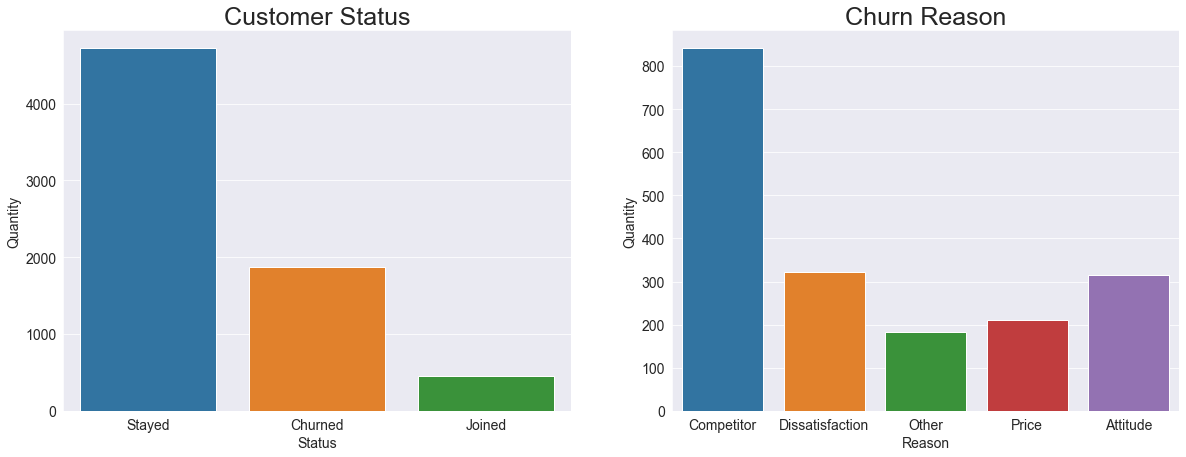

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

sns.countplot(df_churn, x='Customer Status', ax=ax[0])

ax[0].set_title('Customer Status', fontsize=25)
ax[0].set_xlabel('Status', fontsize=14)
ax[0].set_ylabel('Quantity', fontsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

sns.countplot(df_churn, x='Churn Category')

ax[1].set_title('Churn Reason', fontsize=25)
ax[1].set_xlabel('Reason', fontsize=14)
ax[1].set_ylabel('Quantity', fontsize=14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

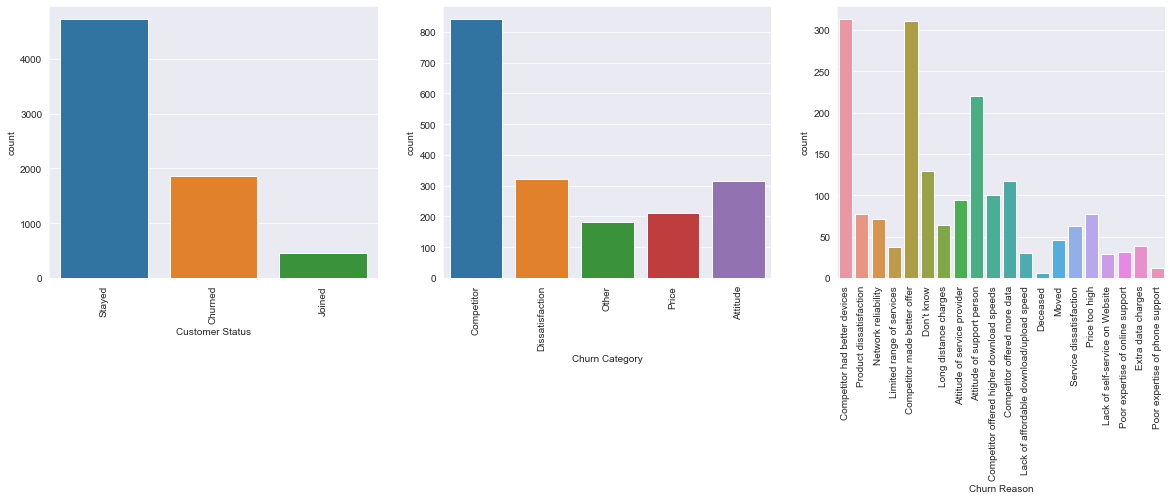

In [18]:
plot_countplot(df_churn, fig_cols=3, figsize=(20, 5), rotation=90)

In [19]:
df_churn['Churn Category'].value_counts()

Competitor         841
Dissatisfaction    321
Attitude           314
Price              211
Other              182
Name: Churn Category, dtype: int64

In [20]:
df_churn.value_counts(dropna=False).sort_index()

Customer Status  Churn Category   Churn Reason                             
Churned          Attitude         Attitude of service provider                   94
                                  Attitude of support person                    220
                 Competitor       Competitor had better devices                 313
                                  Competitor made better offer                  311
                                  Competitor offered higher download speeds     100
                                  Competitor offered more data                  117
                 Dissatisfaction  Lack of self-service on Website                29
                                  Limited range of services                      37
                                  Network reliability                            72
                                  Poor expertise of online support               31
                                  Poor expertise of phone support                12


#### Insights and Solutions

The churn category can be grouped into
* Competitor: client churned because competitor is better
* Intern (Dissatisfaction, Price, Attitude): client churne because we aren't good enough

## Analysing clusters of monthly charge per tenure

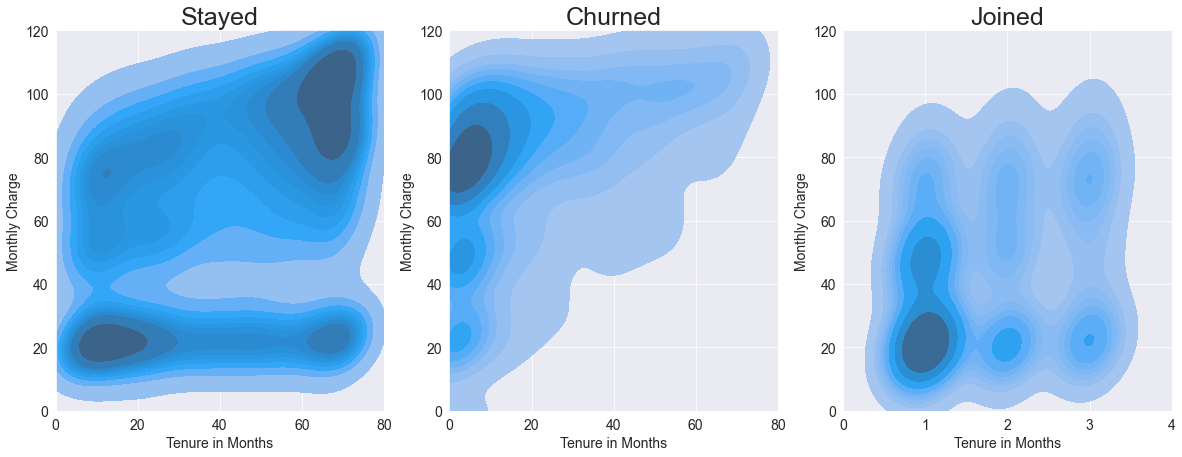

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

for i, status in enumerate(df['Customer Status'].unique()):
    sns.kdeplot(
        data=df[df['Customer Status']==status], 
        x='Tenure in Months', y='Monthly Charge',
        hue='Customer Status', fill=True, ax=ax[i]
    )
    ax[i].set_title(f'{status}', fontsize=25)
    ax[i].set_ylim(0, 120)
    ax[i].set_xlim(0, 80)
    ax[i].get_legend().remove()
    ax[i].tick_params(axis='x', labelsize=14)
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].set_xlabel('Tenure in Months', fontsize=14)
    ax[i].set_ylabel('Monthly Charge', fontsize=14)

ax[2].set_xlim(0, 4);

#### Insights and Solutions

Customers that churn tend to pay higher bills at the start of the tenure

# Feature Selection

The algorithm Boruta is a robust technique for feature selection. 

It compares all features against with itself permuted to get the features with importances higher than the best random feature (if a feature can't even beat a random noise, it can't be good).

The comparison is done for a number of trials to get a binomial distribution that we can infer a probability of being a good feature.

The number of trials will be 20 and the cutoff will be at least 99% of sucess.

In [22]:
# Data Split
X = pd.concat([df_int, df_float, df_object.astype('category')], axis=1)
y = df_churn['Churn Category'].combine_first(df_churn['Customer Status']).replace(['Price', 'Attitude'], 'Dissatisfaction')
y, y_encoder = encoding_labels(y)

In [23]:
feat_df = boruta(X, y, 20)
feat_df

[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Hits,Cumulated Probability
Features,,
Age,20.0,1.000000
Contract,20.0,1.000000
Monthly Charge,20.0,1.000000
Tenure in Months,20.0,1.000000
Avg Monthly GB Download,19.0,0.999999
Avg Monthly Long Distance Charges,18.0,0.999980
Total Charges,6.0,0.057659
Online Security,2.0,0.000201
Number of Referrals,1.0,0.000020


In [24]:
# Data Split
X = pd.concat([df_int, df_float, df_object.astype('category')], axis=1)[feat_df[feat_df['Cumulated Probability'] > 0.99].index]
y = df_churn['Churn Category'].combine_first(df_churn['Customer Status']).replace(['Price', 'Attitude'], 'Dissatisfaction')
y, y_encoder = encoding_labels(y)

X_train, X_calib, X_test, y_train, y_calib, y_test = train_calib_test_split(X, y)
report = model_report(X_test, y_test, y_encoder, 'classifier')

# Model Training

LightGBM is a robust algorithm for tabular data since it can deal with categorical features and null values internally, speeding up the process to produce a good model.

## LightGBM Classifier

### Model

In [25]:
# Model
lgb = LGBMClassifier(n_estimators=10000, max_depth=3, random_state=357)
lgb.fit(X_train, y_train,
        eval_set=[(X_calib, y_calib), (X_train, y_train)],
        categorical_feature=list(X.select_dtypes(include='category').columns),
        callbacks=[early_stopping(25), log_evaluation(10)]);

Training until validation scores don't improve for 25 rounds
[10]	training's multi_logloss: 0.695172	valid_0's multi_logloss: 0.700299
[20]	training's multi_logloss: 0.62911	valid_0's multi_logloss: 0.65252
[30]	training's multi_logloss: 0.60184	valid_0's multi_logloss: 0.642227
[40]	training's multi_logloss: 0.584449	valid_0's multi_logloss: 0.639816
[50]	training's multi_logloss: 0.571006	valid_0's multi_logloss: 0.640573
[60]	training's multi_logloss: 0.558154	valid_0's multi_logloss: 0.641975
Early stopping, best iteration is:
[43]	training's multi_logloss: 0.580247	valid_0's multi_logloss: 0.639577


----------------------Classification Report----------------------
                 precision    recall  f1-score   support

     Competitor       0.35      0.16      0.22       179
Dissatisfaction       0.35      0.10      0.16       179
         Joined       0.54      0.86      0.66        90
          Other       0.00      0.00      0.00        32
         Stayed       0.81      0.99      0.89       929

       accuracy                           0.74      1409
      macro avg       0.41      0.42      0.39      1409
   weighted avg       0.66      0.74      0.68      1409



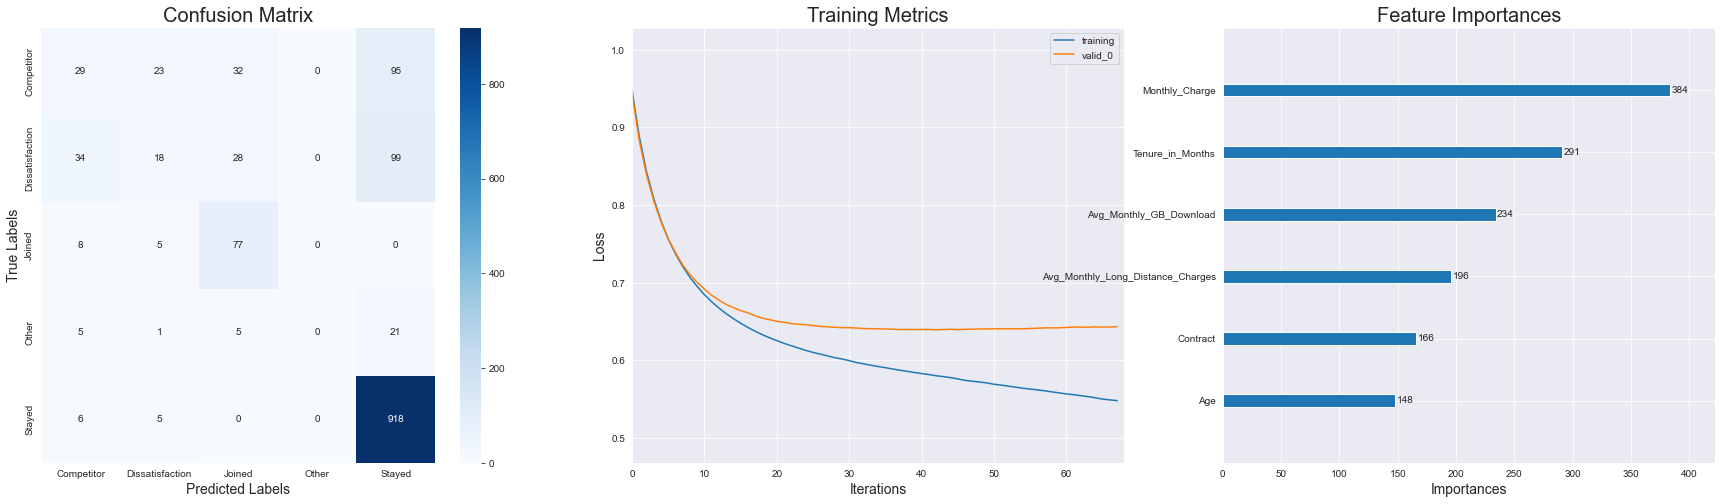

In [26]:
report.lightgbm_classifier(lgb)

#### Analysis

Multiclass with heavy inbalance pose a big problem for prediction, making it hard to detect the minority classes.

The model will need a calibration technique that can measure the uncertainty of the model to give better predictions.

### Calibration

Conformal Prediction is a family of algorithms built to measure uncertainty of any machine learning model.

For problems with heavy inbalance that we are interested in dealing with the minority classes, this is a godsend technique because generally uncertainty in predictions will be heavier on the minority classes.

In business terms, we can simply choose to focus on the few predictions sets that contains the minority classes we are interested.

In [27]:
conformal_lgb = MapieClassifier(estimator=lgb, cv="prefit", method="score", random_state=357, verbose=True)
conformal_lgb.fit(X_calib, y_calib);

----------------------Calibration Report----------------------
test size: 1409
uncalibrated accuracy: 73.95 %
-----------------
alpha: 0.2
coverage: 76.93 %
empty sets: 3
unit sets: 1277
other sets: 129
-----------------
alpha: 0.15
coverage: 82.82 %
empty sets: 0
unit sets: 1085
other sets: 324
-----------------
alpha: 0.1
coverage: 89.5 %
empty sets: 0
unit sets: 891
other sets: 518
-----------------
alpha: 0.05
coverage: 94.32 %
empty sets: 0
unit sets: 668
other sets: 741


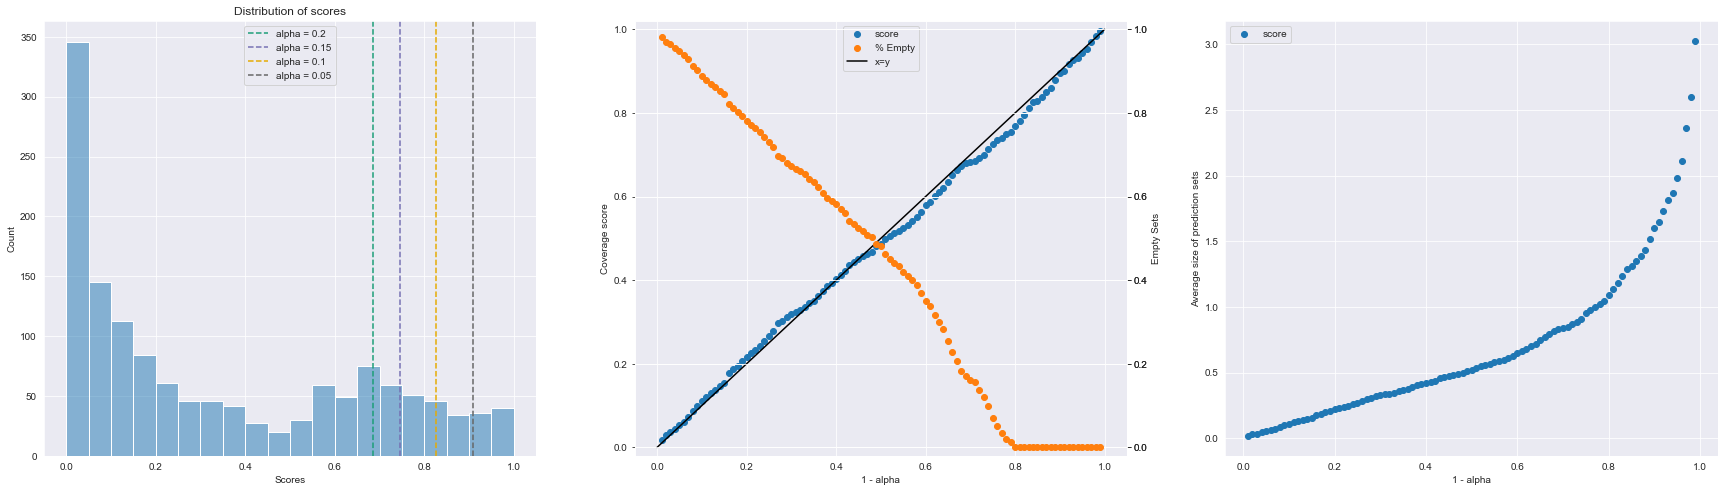

In [28]:
report.calibration_report(conformal_lgb)

#### Analysis

Empty sets reach zero at alpha = 0.2 but will go a bit further choosing alpha = 0.05 because we don't want to miss too many churn candidates.

### Set Intersections

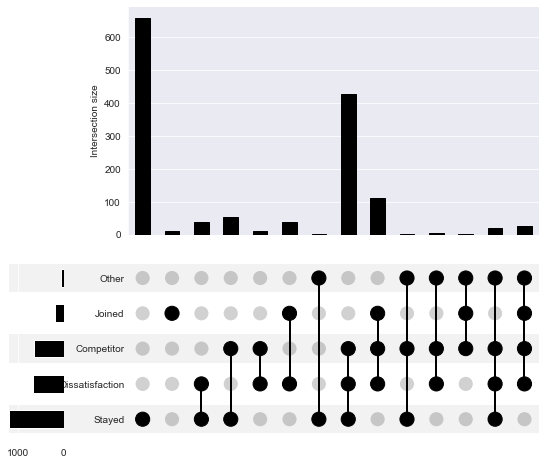

In [29]:
_, y_pred_conformal = conformal_lgb.predict(X_test, alpha=[0.05])
plot_intersections(y_pred_conformal, y_encoder.inverse_transform(lgb.classes_), [0.05])

#### Analysis

At alpha = 0.05 we have a big cluster of people that the model is uncertain if it will churn or not. That said, they are a group of interest to analyse and possible build targeted campaigns.

Lets call it second cluster since it is the second large group identified by the model.

# Analysis of the second cluster

In [30]:
y_pred, y_sets = conformal_lgb.predict(X_test, alpha=0.05)

df_preds = pd.DataFrame(y_sets[:,:,0])
df_preds.columns = y_encoder.inverse_transform(df_preds.columns)
df_preds['Prediction'] = y_encoder.inverse_transform(y_pred)
df_preds['True'] = y_encoder.inverse_transform(y_test)
df_preds.head()

,Competitor,Dissatisfaction,Joined,Other,Stayed,Prediction,True
0,True,True,False,False,True,Stayed,Stayed
1,False,False,False,False,True,Stayed,Stayed
2,True,True,True,False,False,Joined,Joined
3,False,False,False,False,True,Stayed,Stayed
4,True,True,False,False,True,Stayed,Stayed


In [31]:
df_all_churn = (df_preds[(df_preds['Joined']==True) & 
                         (df_preds['Other']==False) & 
                         (df_preds['Stayed']==False) & 
                         (df_preds['Competitor']==True) & 
                         (df_preds['Dissatisfaction']==True)][['Prediction', 'True']]
                .join(X_test.reset_index(drop=True)))

df_all_true = (df_preds[(df_preds['Joined']==False) & 
                        (df_preds['Other']==False) & 
                        (df_preds['Stayed']==True) & 
                        (df_preds['Competitor']==True) & 
                        (df_preds['Dissatisfaction']==True)][['Prediction', 'True']]
               .join(X_test.reset_index(drop=True)))

df_others = X_test.reset_index(drop=True)
df_others = df_preds[df_preds['True']!='Joined'][['Prediction', 'True']].join(df_others[~df_others.index.isin(list(df_all_true.index))], how='inner')

status = list(df_others['True'].value_counts(ascending=False).index)

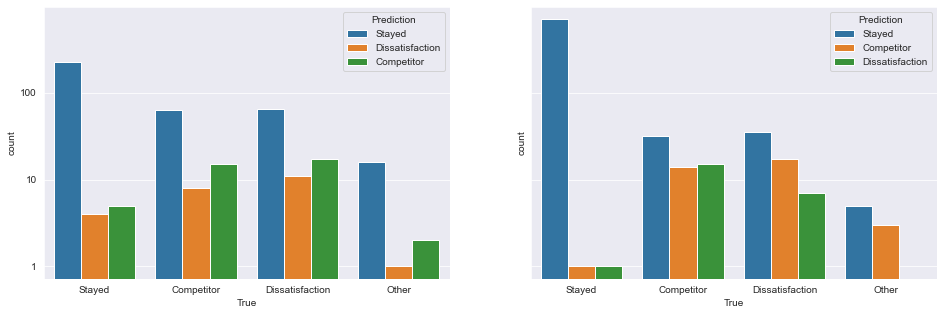

In [32]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.countplot(df_all_true, x='True', hue='Prediction', ax=ax[0], log=True, order=status)
sns.countplot(df_others[df_others['Prediction']!='Joined'], x='True', hue='Prediction', ax=ax[1], log=True, order=status)

ax[0].yaxis.set_major_formatter(ScalarFormatter())
ax[1].yaxis.set_major_formatter(ScalarFormatter());

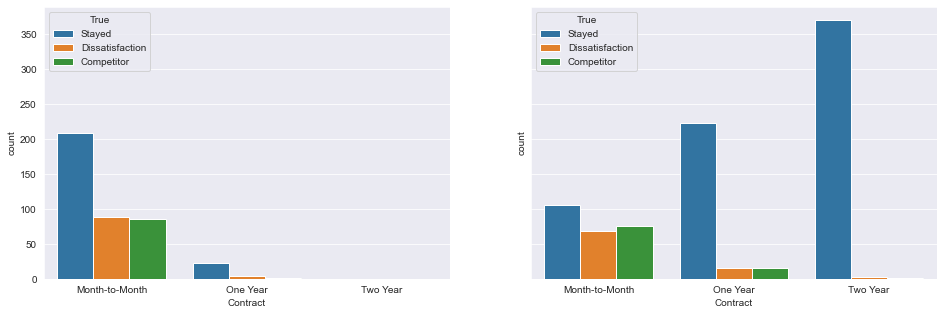

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.countplot(df_all_true[df_all_true['True']!='Other'].sort_values('True', ascending=False), x='Contract', hue='True', ax=ax[0])
sns.countplot(df_others[df_others['True']!='Other'].sort_values('True', ascending=False), x='Contract', hue='True', ax=ax[1]);

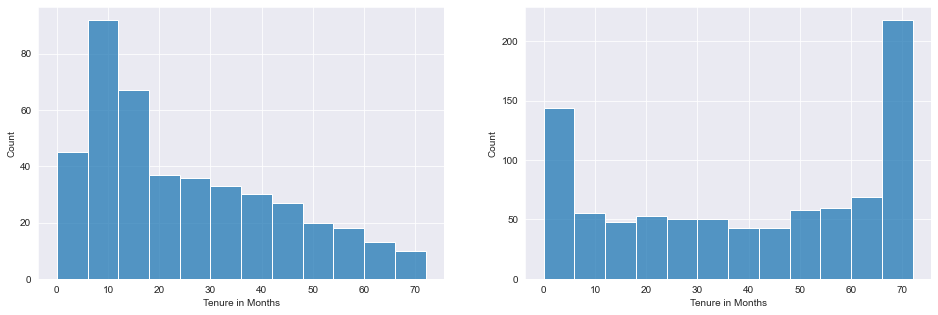

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df_all_true, x='Tenure in Months', ax=ax[0], binwidth=6, binrange=(0, 72))
sns.histplot(df_others, x='Tenure in Months', ax=ax[1], binwidth=6, binrange=(0, 72));

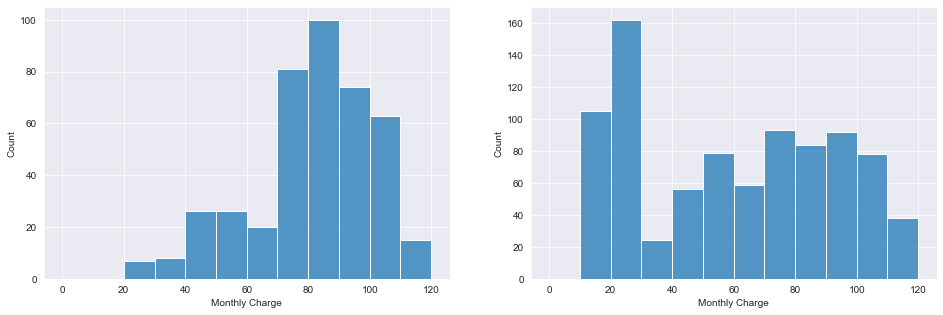

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df_all_true[df_all_true['Monthly Charge']>0], x='Monthly Charge', ax=ax[0], binwidth=10, binrange=(0, 120))
sns.histplot(df_others[df_others['Monthly Charge']>0], x='Monthly Charge', ax=ax[1], binwidth=10, binrange=(0, 120));

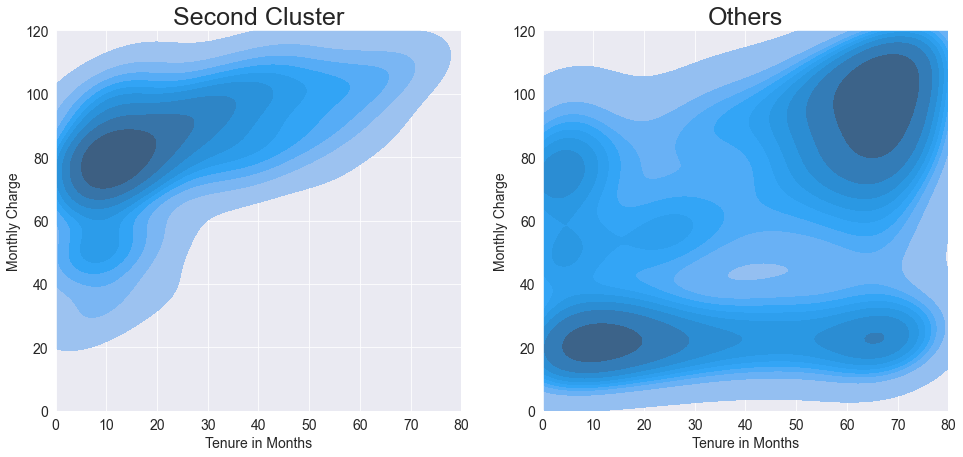

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

sns.kdeplot(df_all_true[df_all_true['Monthly Charge']>0], y='Monthly Charge', x='Tenure in Months', ax=ax[0], fill=True)
sns.kdeplot(df_others[df_others['Monthly Charge']>0], y='Monthly Charge', x='Tenure in Months', ax=ax[1], fill=True);

ax[0].set_title('Second Cluster', fontsize=25)
ax[1].set_title('Others', fontsize=25)

for i in range(2):
   # ax[i].set_title(f'{status}', fontsize=25)
    ax[i].set_ylim(0, 120)
    ax[i].set_xlim(0, 80)
    #ax[i].get_legend().remove()
    ax[i].tick_params(axis='x', labelsize=14)
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].set_xlabel('Tenure in Months', fontsize=14)
    ax[i].set_ylabel('Monthly Charge', fontsize=14)

<AxesSubplot:xlabel='True', ylabel='count'>

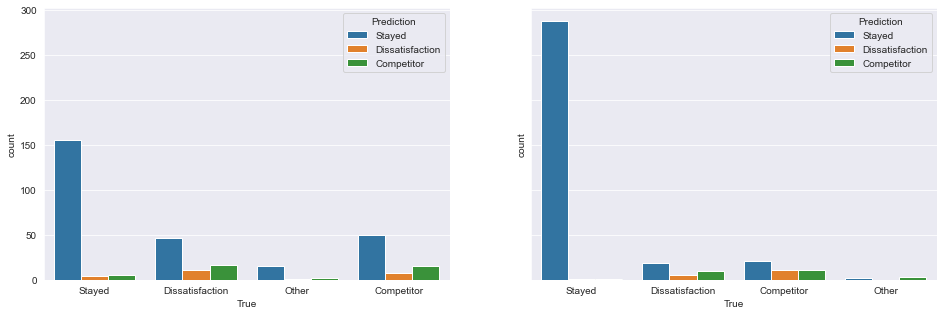

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.countplot(df_all_true[df_all_true['Monthly Charge']>70].sort_values('Prediction', ascending=False), x='True', hue='Prediction', ax=ax[0])
sns.countplot(df_others[(df_others['Monthly Charge']>70) & (df_others['Prediction']!='Joined')].sort_values('Prediction', ascending=False), x='True', hue='Prediction', ax=ax[1])

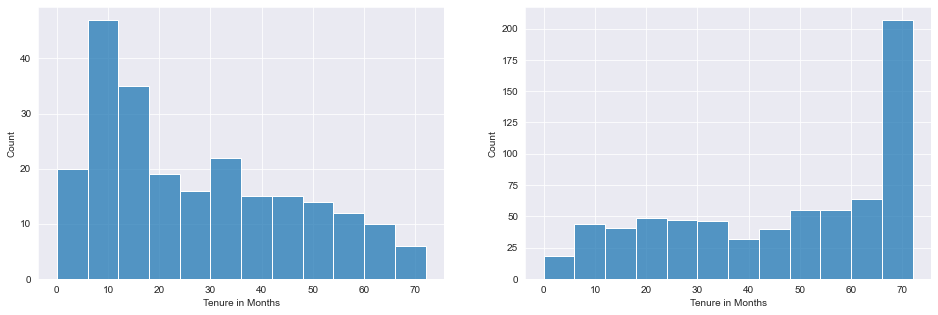

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df_all_true[df_all_true['True']=='Stayed'], x='Tenure in Months', ax=ax[0], binwidth=6, binrange=(0, 72))
sns.histplot(df_others[df_others['True']=='Stayed'], x='Tenure in Months', ax=ax[1], binwidth=6, binrange=(0, 72));

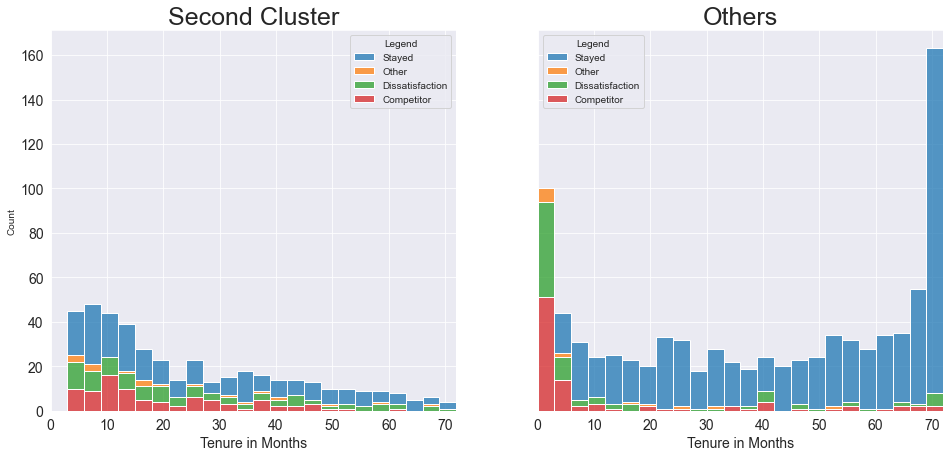

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

sns.histplot(df_all_true[df_all_true['True']!='Others'].sort_values('True', ascending=False).rename(columns={'True': 'Legend'}), x='Tenure in Months', hue='Legend', multiple='stack', ax=ax[0], binwidth=3, binrange=(0, 72))
sns.histplot(df_others[df_others['True']!='Others'].sort_values('True', ascending=False).rename(columns={'True': 'Legend'}), x='Tenure in Months', hue='Legend', multiple='stack', ax=ax[1], binwidth=3, binrange=(0, 72));

ax[0].set_title('Second Cluster', fontsize=25)
ax[1].set_title('Others', fontsize=25)

for i in range(2):
   # ax[i].set_title(f'{status}', fontsize=25)
    ax[i].set_xlim(0, 72)
    #ax[i].get_legend().remove()
    ax[i].tick_params(axis='x', labelsize=14)
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].set_xlabel('Tenure in Months', fontsize=14)

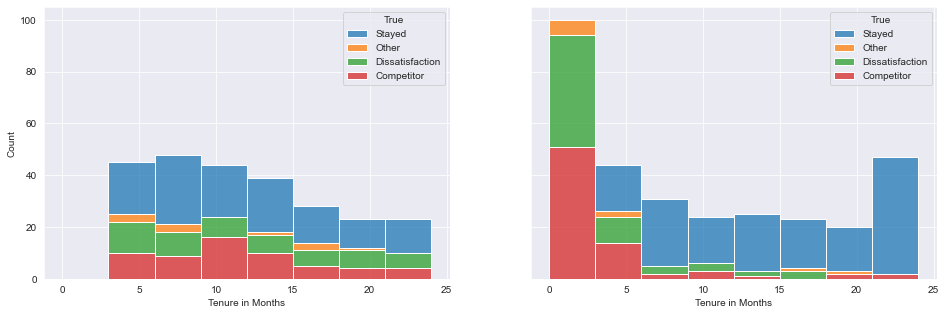

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sns.histplot(df_all_true[df_all_true['True']!='Joined'].sort_values('True', ascending=False), x='Tenure in Months', hue='True', multiple='stack', ax=ax[0], binwidth=3, binrange=(0, 24))
sns.histplot(df_others[df_others['True']!='Joined'].sort_values('True', ascending=False), x='Tenure in Months', hue='True', multiple='stack', ax=ax[1], binwidth=3, binrange=(0, 24));

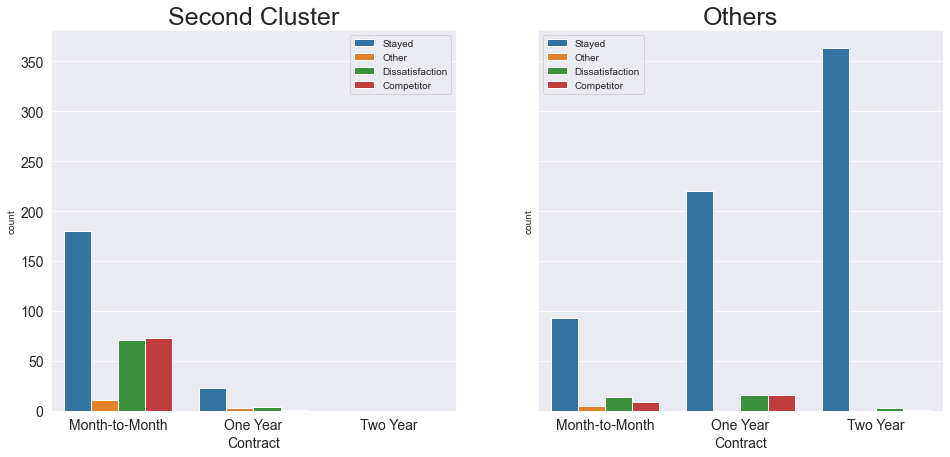

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

sns.countplot(df_all_true[(df_all_true['Tenure in Months']>6) & (df_all_true['True']!='Others')].sort_values('True', ascending=False), x='Contract', hue='True', ax=ax[0])
sns.countplot(df_others[(df_others['Tenure in Months']>6) & (df_others['True']!='Others')].sort_values('True', ascending=False), x='Contract', hue='True', ax=ax[1])

ax[0].set_title('Second Cluster', fontsize=25)
ax[1].set_title('Others', fontsize=25)

for i in range(2):
   # ax[i].set_title(f'{status}', fontsize=25)
    #ax[i].set_xlim(0, 72)
    #ax[i].get_legend().remove()
    ax[i].tick_params(axis='x', labelsize=14)
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].set_xlabel('Contract', fontsize=14)

ax[0].legend(loc=1);
ax[1].legend(loc=2);

# Results

The model combined with conformal prediction can segment a cluster of customers (the second cluster) that tends to churn a lot, and the first business action should be on top of those clients.

They overlap highly with the overal number of churn while all others comnbine overlap with the type of customers that won't churn.

Thinking of targeted campaigns, these customers are a good fit for that since a big chunk of churners are indentified there, reducing costs of wide campaigns and not losing to many churners for misclassifications of the model without the conformal prediction.